In [1]:
!nvidia-smi

Thu Jan 16 13:54:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   37C    P0    53W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   27C    P8     5W / 250W |  10929MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [12]:
neg_path = load_path('train', 'n', 'neg', data = 'sm_x160')
# redspot_path = load_path('train', 'h', 'redspot', data = 'sm_x160')
# angio_path = load_path('train', 'h', 'angio', data = 'sm_x160')
# active_path = load_path('train', 'h', 'active', data = 'sm_x160')
ero_path = load_path('train', 'd', 'ero', data = 'sm_x160')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm_x160')
str_path = load_path('train', 'd', 'str', data = 'sm_x160')

print("negative:",neg_path.shape)
# print("red spot:",redspot_path.shape)
# print("angioectasia:",angio_path.shape)
# print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (50856,)
erosion: (128160,)
ulcer: (123840,)
stricture: (15680,)


In [13]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
# redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
# angio_train_path, angio_valid_path = train_valid_split(angio_path)
# active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
# print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
# print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
# print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (43228,) (21678,)
erosion: (108936,) (54844,)
ulcer: (105264,) (52973,)
stricture: (13328,) (6755,)


# Model

In [14]:
input_h = 512
input_w = 512
input_ch = 3

k_chs = [16, 16, 16, 32, 32, 32, 64]
n_conv_block = len(k_chs)
n_hid_node = [100, 50]
n_hid_layer = len(n_hid_node)
n_output = 2

In [15]:
class CE_cnn:
    def __init__(self, k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output):
        self.k_chs = k_chs
        self.n_conv_block = n_conv_block
        self.n_hid_node = n_hid_node
        self.n_hid_layer = n_hid_layer
        self.n_output = n_output
    def conv_block(self, x, k_chs, n_conv_block):
        for i in range(1, n_conv_block + 1):
            if i == 1:
                conv = tf.layers.conv2d(inputs = x, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            else:
                conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                    activation= tf.nn.relu, name = 'block_{}_conv_2'.format(i))
            conv = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2, name = 'block_{}_maxp'.format(i))
        return conv
    def fc_layers(self, x, n_hid_node, n_hid_layer, n_output):
        hidden = tf.layers.flatten(x)
        for i in range(1, n_hid_layer + 1):
            hidden = tf.layers.dense(inputs = hidden, units = n_hid_node[i-1],activation = tf.nn.relu, name = 'fc_{}'.format(i))
            hidden = tf.layers.dropout(hidden, rate = 0.3, training = is_training)
        score = tf.layers.dense(inputs = hidden, units = n_output, name = 'score')
        return score
    
    def inf(self, x):
        conv = self.conv_block(x, self.k_chs, self.n_conv_block)
        score = self.fc_layers(conv, self.n_hid_node, self.n_hid_layer, self.n_output)
        return score

In [16]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')
LR = tf.placeholder(tf.float32)

model = CE_cnn(k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

# Training

damped_exp_LR(40000, alpha = 0.00005) <br>
n_batch (per class) = 50  <br>
cal_interval = 10 <br>
prt_interval = 100 <br>

In [8]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

a_train_path = shuffle(d_train_path, None)
a_valid_path = shuffle(d_valid_path, None)

In [9]:
damped_exp_LR

<function ce_utils.damped_exp_LR(n_iter, f=20, A=0.0005, alpha=0.0002, gamma=0.1)>

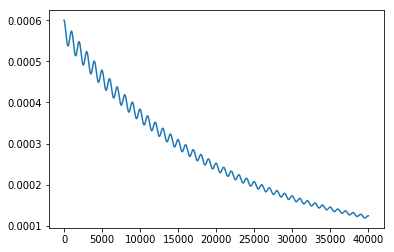

In [10]:
D_lr = damped_exp_LR(40000, alpha = 0.00005)

plt.plot(D_lr)

## training negative images: 254,280 (x40)

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[## training negative images: 254,280 (x40)-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0116 13:57:34.914797 140333566019328 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 78.00 %    || 78.00 %    || 0.42064109 || 0.44321465
--------------------------------------------------------------
[*200] || 87.00 %    || 82.00 %    || 0.30876490 || 0.40382811
--------------------------------------------------------------
[*300] || 90.00 %    || 81.00 %    || 0.26931199 || 0.42772400
--------------------------------------------------------------
[*400] || 91.00 %    || 92.00 %    || 0.25602889 || 0.23768896
--------------------------------------------------------------
[*500] || 87.00 %    || 89.00 %    || 0.30454820 || 0.28473973
--------------------------------------------------------------
[*600] || 89.00 %    || 90.00 %    || 0.28533253 || 0.24704476
--------------------------------------------------------------
[*700] || 93.00 %    || 85.00 %    || 0.24342825 || 0.32553542
--------------------------------------------------------------
[*800] || 87.00 %    || 92.00 %    || 0.30554599 || 0.24006066
-------------------------------------------------------

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 4 dimension(s)

## training negative images: 50,856 (x8)

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_NX8D_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 76.00 %    || 73.00 %    || 0.50178820 || 0.52169776
--------------------------------------------------------------
[*200] || 73.00 %    || 71.00 %    || 0.52086353 || 0.53325087
--------------------------------------------------------------
[*300] || 75.00 %    || 77.00 %    || 0.47764924 || 0.49510601
--------------------------------------------------------------
[*400] || 82.00 %    || 82.00 %    || 0.47297981 || 0.49496049
--------------------------------------------------------------
[*500] || 83.00 %    || 83.00 %    || 0.37748641 || 0.37598938
--------------------------------------------------------------
[*600] || 65.00 %    || 78.00 %    || 0.62980795 || 0.44059631
--------------------------------------------------------------
[*700] || 89.00 %    || 88.00 %    || 0.30607358 || 0.28210774
--------------------------------------------------------------
[*800] || 96.00 %    || 92.00 %    || 0.14362592 || 0.2

[6500] || 100.00 %    || 99.00 %    || 0.00482841 || 0.01828024
--------------------------------------------------------------
[6600] || 98.00 %    || 98.00 %    || 0.02705128 || 0.09274064
--------------------------------------------------------------
[6700] || 99.00 %    || 99.00 %    || 0.03248769 || 0.01620400
--------------------------------------------------------------
[6800] || 100.00 %    || 100.00 %    || 0.00837261 || 0.00299387
--------------------------------------------------------------
[6900] || 98.00 %    || 99.00 %    || 0.03954677 || 0.01585154
--------------------------------------------------------------
[7000] || 98.00 %    || 99.00 %    || 0.04514101 || 0.05353829
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00622352 || 0.02281006
--------------------------------------------------------------
[7200] || 100.00 %    || 99.00 %    || 0.01067819 || 0.03029350
-------------------------------------------------

[13000] || 100.00 %    || 100.00 %    || 0.00295814 || 0.00183532
--------------------------------------------------------------
[13100] || 99.00 %    || 99.00 %    || 0.01014515 || 0.04688881
--------------------------------------------------------------
[13200] || 100.00 %    || 100.00 %    || 0.00544467 || 0.00858392
--------------------------------------------------------------
[13300] || 100.00 %    || 99.00 %    || 0.00864365 || 0.01110103
--------------------------------------------------------------
[13400] || 100.00 %    || 99.00 %    || 0.00542608 || 0.02944711
--------------------------------------------------------------
[13500] || 99.00 %    || 99.00 %    || 0.02964458 || 0.02092612
--------------------------------------------------------------
[13600] || 100.00 %    || 98.00 %    || 0.00777044 || 0.05551571
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00143956 || 0.00148140
--------------------------------------

[19400] || 100.00 %    || 99.00 %    || 0.00035600 || 0.00801067
--------------------------------------------------------------
[19500] || 100.00 %    || 100.00 %    || 0.00014939 || 0.00082757
--------------------------------------------------------------
[19600] || 100.00 %    || 99.00 %    || 0.00033263 || 0.04022799
--------------------------------------------------------------
[19700] || 100.00 %    || 99.00 %    || 0.00081466 || 0.01565471
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00039795 || 0.00151599
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00129336 || 0.00972246
--------------------------------------------------------------
[20000] || 100.00 %    || 99.00 %    || 0.00124765 || 0.02582899
--------------------------------------------------------------
[20100] || 100.00 %    || 100.00 %    || 0.00051416 || 0.00154380
-----------------------------------

[25800] || 100.00 %    || 99.00 %    || 0.00023725 || 0.02555008
--------------------------------------------------------------
[25900] || 100.00 %    || 99.00 %    || 0.00406350 || 0.05628923
--------------------------------------------------------------
[26000] || 100.00 %    || 99.00 %    || 0.00229350 || 0.05497643
--------------------------------------------------------------
[26100] || 100.00 %    || 98.00 %    || 0.00008409 || 0.05646372
--------------------------------------------------------------
[26200] || 100.00 %    || 100.00 %    || 0.00018589 || 0.00075070
--------------------------------------------------------------
[26300] || 100.00 %    || 100.00 %    || 0.00088045 || 0.00027773
--------------------------------------------------------------
[26400] || 100.00 %    || 99.00 %    || 0.00043472 || 0.01384894
--------------------------------------------------------------
[26500] || 100.00 %    || 100.00 %    || 0.00019591 || 0.00055837
------------------------------------

[32200] || 100.00 %    || 99.00 %    || 0.00014843 || 0.10414167
--------------------------------------------------------------
[32300] || 100.00 %    || 100.00 %    || 0.00011488 || 0.00529198
--------------------------------------------------------------
[32400] || 100.00 %    || 99.00 %    || 0.00051707 || 0.00902348
--------------------------------------------------------------
[32500] || 100.00 %    || 99.00 %    || 0.00049545 || 0.06514771
--------------------------------------------------------------
[32600] || 100.00 %    || 100.00 %    || 0.00162141 || 0.00037749
--------------------------------------------------------------
[32700] || 100.00 %    || 100.00 %    || 0.00011166 || 0.00303009
--------------------------------------------------------------
[32800] || 100.00 %    || 100.00 %    || 0.00007031 || 0.00043962
--------------------------------------------------------------
[32900] || 100.00 %    || 100.00 %    || 0.00010121 || 0.00010128
----------------------------------

KeyboardInterrupt: 

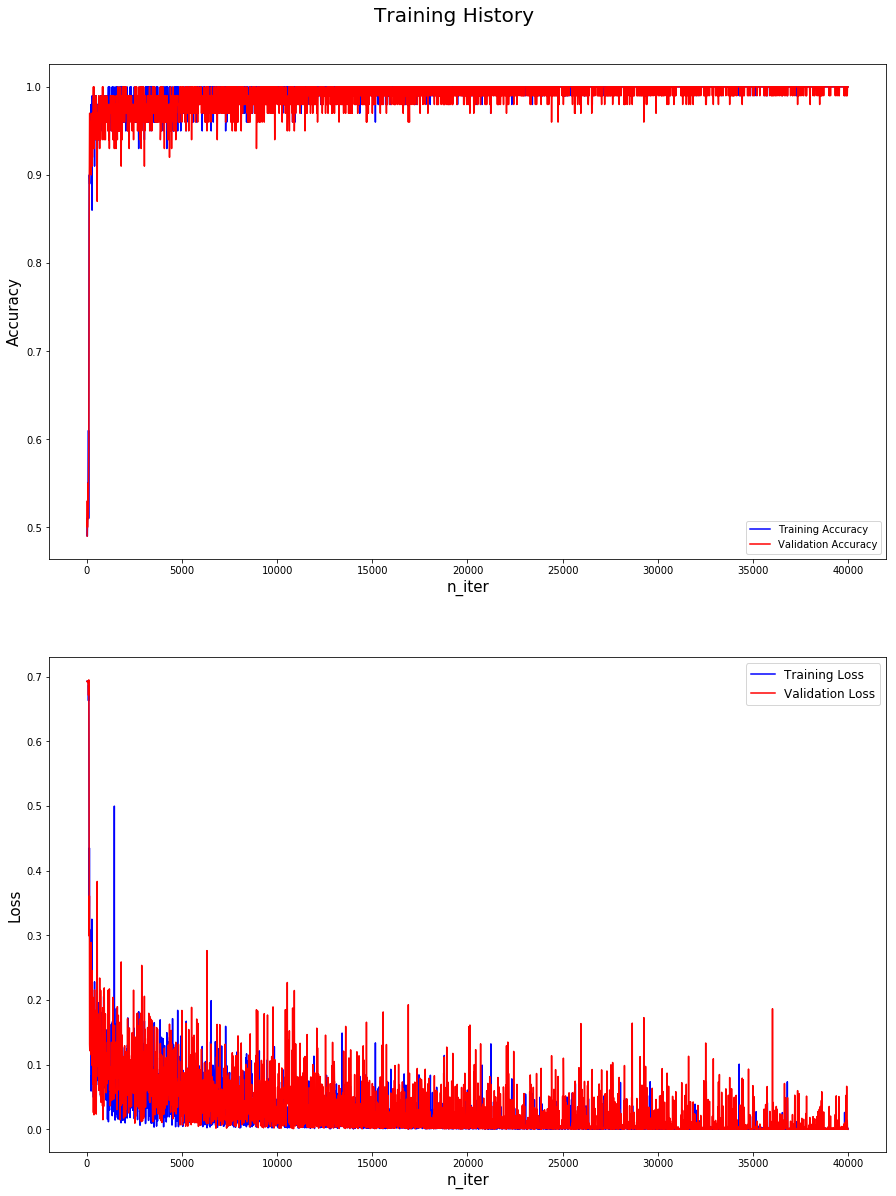

In [14]:
hist.plot(cal_interval)   